In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
# Параметри області та сітки
x0, xe = 0.0, 1.0
y0, ye = 0.0, 1.0
Nx, Ny = 50, 50
dx = (xe - x0) / (Nx - 1)
dy = (ye - y0) / (Ny - 1)

xx, yy = np.meshgrid(np.linspace(x0, xe, Nx), np.linspace(y0, ye, Ny), indexing='ij')

In [3]:
# область пухлини: диск радіусом 0.2 в центрі (0.5,0.5)
T_body   = 36.6
T_tumor  = 42.0
center_x, center_y = 0.5, 0.5
tumor_radius       = 0.2
tumor_mask         = (xx - center_x)**2 + (yy - center_y)**2 <= tumor_radius**2
healthy_mask       = ~tumor_mask

In [4]:
# Фізика
T_env, alpha, k = 36.6, 1e-2, 0.1

In [5]:
# Часова сітка
dt = min(dx, dy)**2 / (4*alpha)
Tf = 1.0
Nt = int(Tf/dt)

In [6]:
# Ваги у функціоналі
omega1 = 10.0
omega2 = 1e-5
T_des = 42.0*np.ones((Nx, Ny))

In [7]:
def laplacian(T):
    """Центральні різниці для лапласіана з Діріхле на границях."""
    T_xx = (np.roll(T,-1,0)-2*T+np.roll(T,1,0))/dx**2
    T_yy = (np.roll(T,-1,1)-2*T+np.roll(T,1,1))/dy**2
    T_xx[0,:]=T_xx[-1,:]=0
    T_yy[:,0]=T_yy[:,-1]=0
    return T_xx+T_yy

In [8]:
def solve_forward(u):
    """Явна схема вперед, повертає історію T[n,:,:]."""
    # стартове поле: пухлина 55°C, здорова тканина 36.6°C
    T = np.where(tumor_mask, T_tumor, T_body)
    hist = np.zeros((Nt+1,Nx,Ny))
    hist[0] = T.copy()
    for n in range(Nt):
        lap = laplacian(T)
        T = T + dt*(alpha*lap - k*(T-T_env) + u[n])
        T[0,:]=T[-1,:]=T_env
        T[:,0]=T[:,-1]=T_env
        hist[n+1]=T
    return hist

In [9]:
def solve_adjoint(T_hist):
    psi = 2*omega1*(T_des - T_hist[-1])   
    psi_hist = np.zeros((Nt+1, Nx, Ny))
    psi_hist[-1] = psi.copy()
    for n in reversed(range(Nt)):
        lap_psi = laplacian(psi)
        psi = psi + dt*(alpha * lap_psi - k*psi + 2*omega1*(T_des - T_hist[n]))
        psi[0,:] = psi[-1,:] = 0
        psi[:,0] = psi[:,-1] = 0
        psi_hist[n] = psi
    return psi_hist


In [10]:
def compute_cost(T_hist, u):
    """Частина за T та частина за u."""
    Jt = omega1 * np.sum((T_hist-T_des)**2) * dx*dy*dt
    Ju = omega2 * np.sum(u**2)      * dx*dy*dt
    return Jt + Ju

In [11]:
def optimize_control(max_iter=21, alpha_step=1e-2):
    """Градієнтний спуск для u."""
    u = np.zeros((Nt,Nx,Ny))
    cost_hist = []
    for it in range(max_iter):
        Th = solve_forward(u)
        J = compute_cost(Th, u)
        cost_hist.append(J)
        print(f"Iter {it}, cost = {J:.4f}")
        psi_h = solve_adjoint(Th)
        grad = 2*omega2*u - psi_h[:-1]  # градієнт
        u -= alpha_step * grad         # оновлення
        u = np.clip(u, 0, None)        # u >= 0
        # обмежуємо керування лише в області пухлини
        u *= tumor_mask[np.newaxis, :, :]
    return u, cost_hist, Th[-1]

In [12]:
# Запуск
u_opt, cost_hist, T_final = optimize_control()
Th_opt = solve_forward(u_opt)

Iter 0, cost = 254.2909
Iter 1, cost = 250.8103
Iter 2, cost = 248.0568
Iter 3, cost = 245.8616
Iter 4, cost = 244.0958
Iter 5, cost = 242.6611
Iter 6, cost = 241.4821
Iter 7, cost = 240.5014
Iter 8, cost = 239.6749
Iter 9, cost = 238.9690
Iter 10, cost = 238.3577
Iter 11, cost = 237.8212
Iter 12, cost = 237.3441
Iter 13, cost = 236.9147
Iter 14, cost = 236.5240
Iter 15, cost = 236.1650
Iter 16, cost = 235.8325
Iter 17, cost = 235.5224
Iter 18, cost = 235.2315
Iter 19, cost = 234.9572
Iter 20, cost = 234.6975


In [13]:
# Перевірка розподілу оптимального керування u
print("Max value u:", u_opt.max())
print("Min value u:", u_opt.min())

Max value u: 19.86648449734088
Min value u: 0.0


In [14]:
limited_Nx, limited_Ny = 6, 6
limited_dx, limited_dy = dx * (Nx / limited_Nx), dy * (Ny / limited_Ny)

header = "| x/y   " + " | ".join([f"y={round(j * limited_dy, 2):<5}" for j in range(limited_Ny)]) + " |\n"
separator = "|-------" + "|".join(["------" for _ in range(limited_Ny)]) + "|\n"
rows = ""
for i in range(limited_Nx):
    row_values = " | ".join([f"{T_final[int(i * (Nx / limited_Nx)), int(j * (Ny / limited_Ny))]:<5.2f}" for j in range(limited_Ny)])
    rows += f"| x={round(i * limited_dx, 2):<5} | {row_values} |\n"

table_10x10 = header + separator + rows
print(table_10x10)

| x/y   y=0.0   | y=0.17  | y=0.34  | y=0.51  | y=0.68  | y=0.85  |
|-------------|------|------|------|------|------|
| x=0.0   | 36.60 | 36.60 | 36.60 | 36.60 | 36.60 | 36.60 |
| x=0.17  | 36.60 | 36.72 | 37.20 | 37.67 | 37.20 | 36.72 |
| x=0.34  | 36.60 | 37.20 | 39.71 | 42.20 | 39.71 | 37.20 |
| x=0.51  | 36.60 | 37.67 | 42.20 | 43.54 | 42.20 | 37.67 |
| x=0.68  | 36.60 | 37.20 | 39.71 | 42.20 | 39.71 | 37.20 |
| x=0.85  | 36.60 | 36.72 | 37.20 | 37.67 | 37.20 | 36.72 |



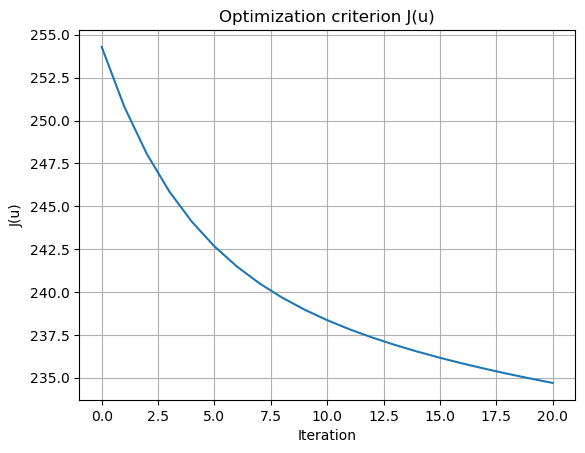

In [15]:
plt.figure(); 
plt.title('Optimization criterion J(u)')
plt.plot(cost_hist, '-'); 
plt.xlabel('Iteration'); 
plt.ylabel('J(u)'); 
plt.grid()
plt.show()

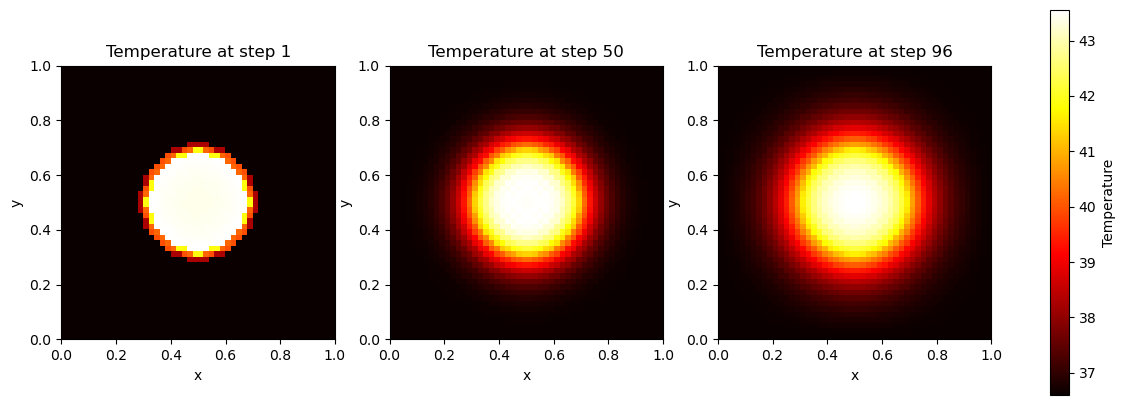

In [16]:
# Візуалізація розподілу температури на ітераціях 2, 10 та фінальній
frames = [1, 50, Th_opt.shape[0] - 1]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, frame in zip(axes, frames):
    im = ax.imshow(Th_opt[frame], extent=[x0, xe, y0, ye], origin='lower', cmap='hot')
    ax.set_title(f'Temperature at step {frame}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
fig.colorbar(im, ax=axes.tolist(), orientation='vertical', label='Temperature')
plt.show()

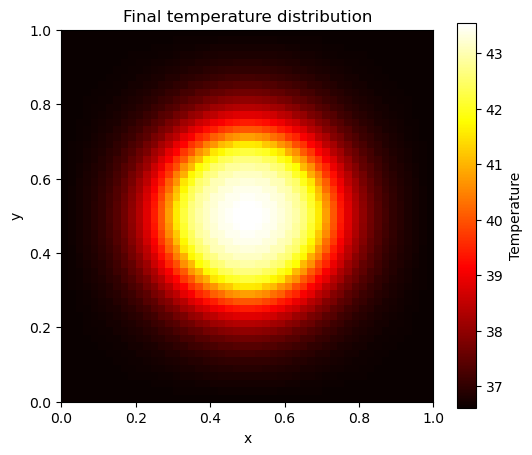

In [17]:
plt.figure(figsize=(6, 5))
plt.imshow(T_final, extent=[x0, xe, y0, ye], origin='lower', cmap='hot')
plt.colorbar(label='Temperature')
plt.title('Final temperature distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

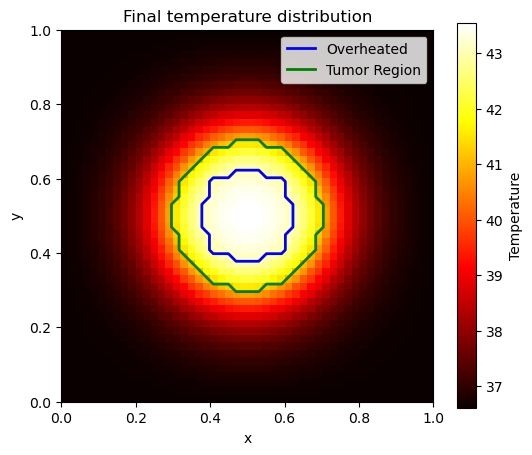

In [18]:
T_max = 43.0

exceed_mask = (T_final > T_max)

overheat = exceed_mask

tumor_region = tumor_mask

plt.figure(figsize=(6, 5))
plt.imshow(T_final, extent=[x0, xe, y0, ye], origin='lower', cmap='hot')
plt.colorbar(label='Temperature')

# контур перегрітих здорових клітин
cs1 = plt.contour(xx, yy, overheat, levels=[0.5], colors='blue', linewidths=2)
# контур самої області пухлини
cs2 = plt.contour(xx, yy, tumor_region, levels=[0.5], colors='green', linewidths=2)

# створюємо умовні лінії для легенди
blue_line  = Line2D([0], [0], color='blue',  lw=2)
green_line = Line2D([0], [0], color='green', lw=2)

plt.legend(
    [blue_line, green_line],
    ['Overheated', 'Tumor Region'],
    loc='upper right'
)

plt.title('Final temperature distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

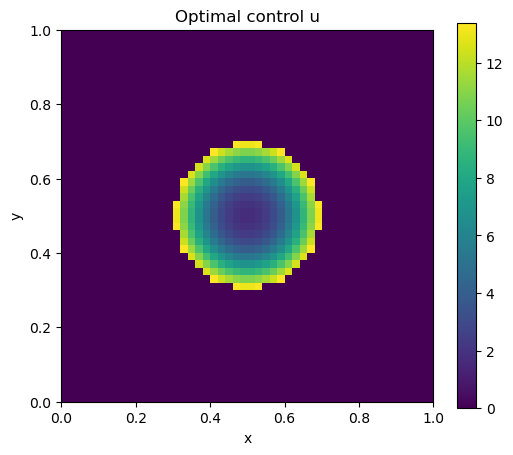

In [19]:
# Візуалізація середнього розподілу оптимального керування u по всіх кадрах
u_mean = u_opt.mean(axis=0)
plt.figure(figsize=(6, 5))
plt.imshow(u_mean, extent=[x0, xe, y0, ye], origin='lower', cmap='viridis')
plt.colorbar()
plt.title('Optimal control u')
plt.xlabel('x')
plt.ylabel('y')
plt.show()